In [26]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
import matplotlib.cm as mcm
import matplotlib.colors as mcol
#from scipy.optimize import curve_fit
#from matplotlib import ticker
#from matplotlib.gridspec import GridSpec
import scipy.stats as sts
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mutual_info_score
from astropy.cosmology import Planck18 as cosmo
import numpy.ma as nma
from sklearn.neighbors import KernelDensity

plt.style.use('./presentation.mplstyle')


In [17]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(sources.shape)

smorph = pd.read_csv('saga_morph.csv')
print(smorph.shape)

(6337, 26)
(6211, 78)


In [3]:
rd2deg = (180*3600)/np.pi

#mst = sources['logM'].iloc[morph_all[:,0,0]]
#zspec = sources['zspec'].iloc[morph_all[:,0,0]]
#res = 1e6*(0.262*cosmo.comoving_distance(zspec).value)/rd2deg

npr = {1:[[0.3,1.0],r'${\it Gini}$'],2:[[-2,-0.5],r'$M_{20}$'],5:[[1.5,4],r'$Concentration$'],6:[[-0.75,0.75],r'$Asymmetry$'],7:[[-0.1,0.1],r'$Smoothness$']}

In [4]:
bands = {'g':[mcm.Blues,'tab:blue'],'r':[mcm.Greens,'tab:green'],'i':[mcm.Oranges,'tab:orange'],'z':[mcm.Reds,'tab:red']}

labels = [r'${\it g}$', r'${\it r}$', r'${\it i}$', r'${\it z}$']
positions = [0, 1, 2, 3]

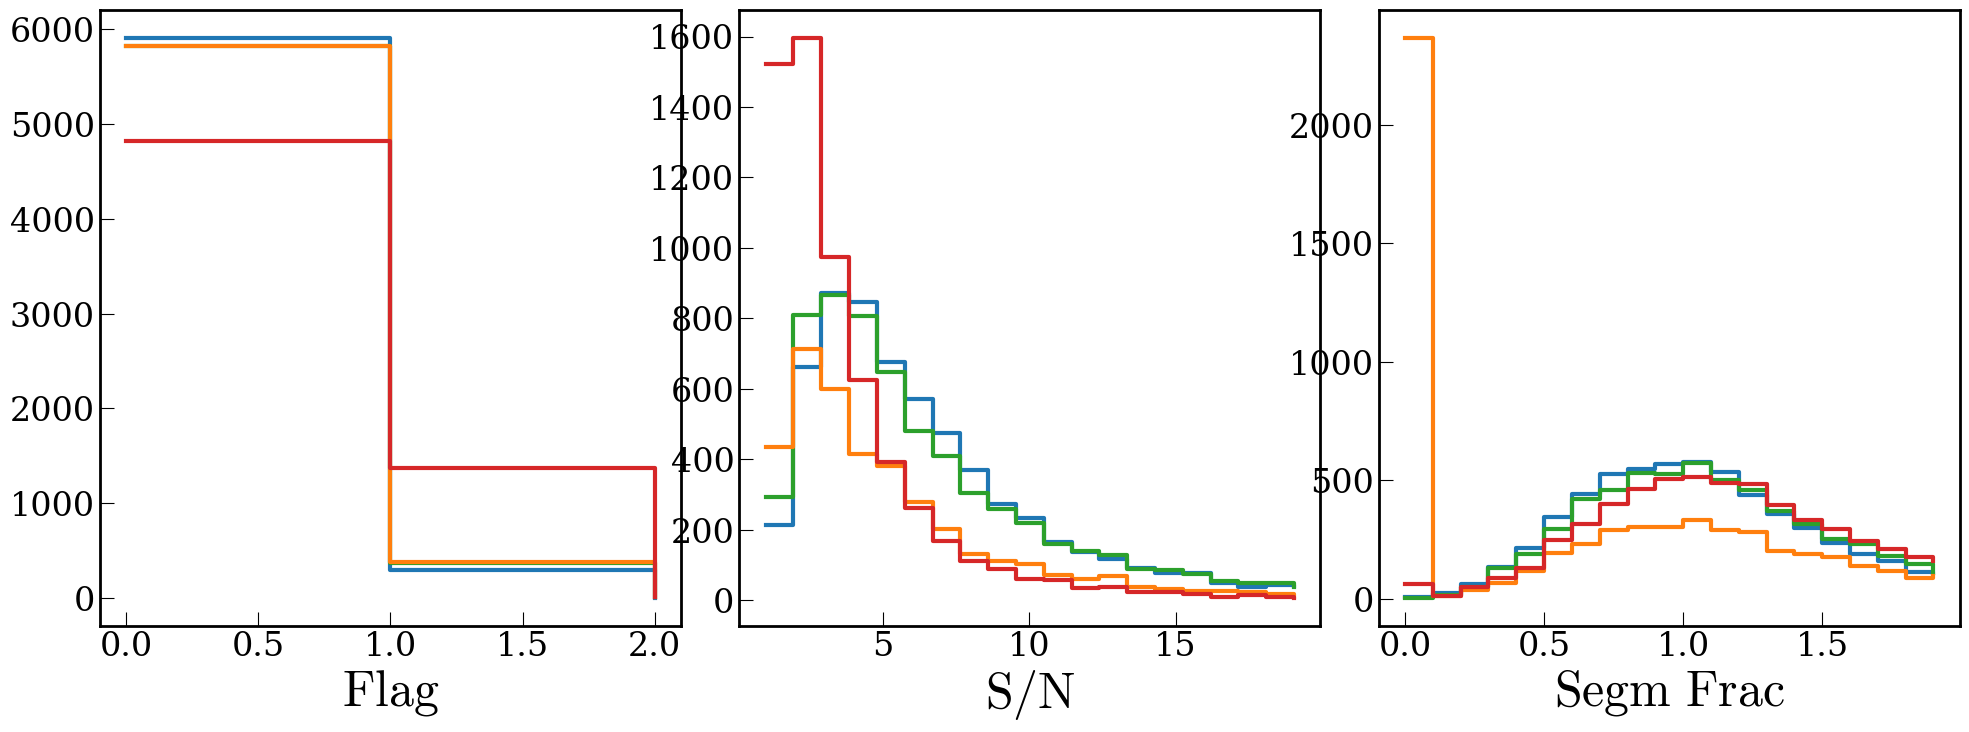

In [6]:
fig,ax=plt.subplots(1,3,figsize=(24,8))

for i,key in enumerate(bands):
    if

    hist, bin_edg = np.histogram(smorph['flag_'+key], bins=np.arange(0,4,1))
    ax[0].step(bin_edg[:-1],hist,where='post',lw=3,color=bands[key][1])

    hist, bin_edg = np.histogram(smorph['snr_pix_'+key], bins=np.linspace(1,20,21))
    ax[1].step(bin_edg[:-1],hist,where='post',lw=3,color=bands[key][1])

    hist, bin_edg = np.histogram(smorph['segm_petr_'+key], bins=np.linspace(0,2,21))
    ax[2].step(bin_edg[:-1],hist,where='post',lw=3,color=bands[key][1])

ax[0].set_xlabel(r'${Flag}$',fontsize=36)
ax[1].set_xlabel(r'$S/N$',fontsize=36)
ax[2].set_xlabel(r'$Segm\ Frac$',fontsize=36)

plt.subplots_adjust(hspace=0.0,wspace=0.1)


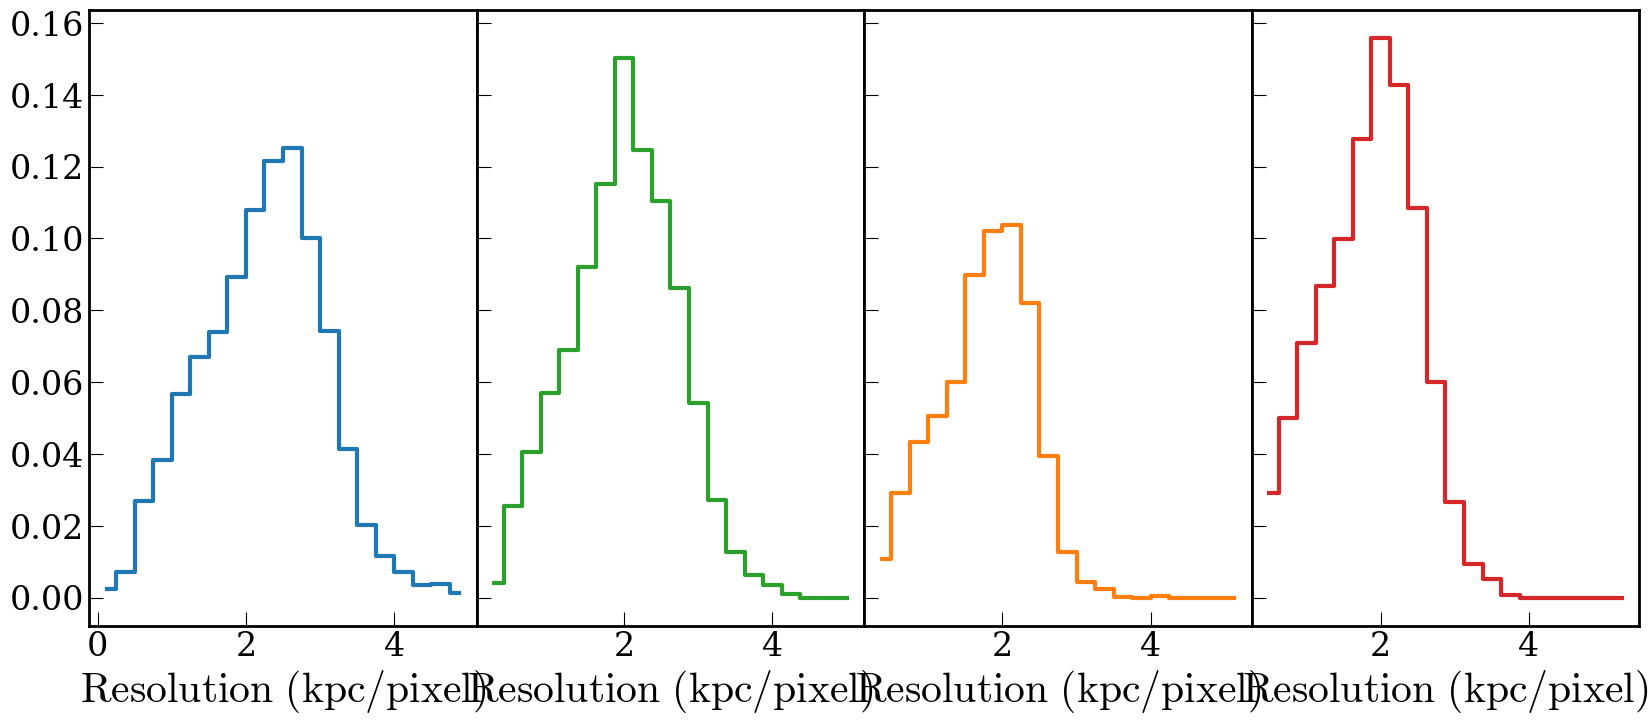

In [20]:
fig,ax=plt.subplots(1,4,figsize=(20,8),sharey='row',sharex='col')

res_bins = np.linspace(0,5,21)

for i,k in enumerate(bands):
    res = 1e3*sources['psfsize_'+k].iloc[smorph['ind1']]*cosmo.comoving_distance(sources['zspec'].iloc[smorph['ind1']]).value/rd2deg
    bin_sat, bin_edg = np.histogram(res,bins=res_bins)
    bin_edg+=0.5*(bin_edg[1]-bin_edg[0])
    ax[i].step(bin_edg[:-1],bin_sat/len(sources['ind']),c=bands[k][1],lw=3,where='mid')

    #ax[i].text(1.25,3,r'${\it '+k+'}$',fontsize=44)
    ax[i].set_xlabel(r'$Resolution\ (kpc/pixel)$',fontsize=26)
#ax[1,0].set_ylabel( r'$CCF$',fontsize=40)
        
plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.savefig('PSFdistributions.pdf',bbox_inches='tight')


In [53]:
def hess_arr(x_val,y_val,xy_ext,nbins):
    x_val = (x_val - xy_ext[0])/(xy_ext[1]-xy_ext[0])
    y_val = (y_val - xy_ext[2])/(xy_ext[3]-xy_ext[2])
    dz=1.0/nbins
    
    
    xx,yy=np.meshgrid(np.arange(dz,1+dz,dz),np.arange(dz,1+2*dz,dz))
    xy_sample = np.vstack([yy[:-1].ravel(), xx[:-1].ravel()]).T
    xy_train  = np.vstack([y_val,x_val]).T

    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.08)
    kde_skl.fit(xy_train)
    hss_est = np.exp(np.reshape(kde_skl.score_samples(xy_sample),(nbins,nbins)))
    #hss_est = hss_est/((xy_ext[3] - xy_ext[2])*(xy_ext[1] - xy_ext[0]))
    hss_est = hss_est/np.sum(hss_est)
    #hss_est = hss_est/np.amax(hss_est)
    #print(dz*dz*np.sum(hss_est))

    return hss_est

def median_hist_2d(AXIS,X,Y,XYext,Xlabel,Ylabel,CMAP,Z=None,Zext=None,Zlabel=None):
        Xval = (X - XYext[0])/(XYext[1]-XYext[0])
        Yval = (Y - XYext[2])/(XYext[3]-XYext[2])
        UV = np.linspace(0,1,16)

        #ax_scatter.scatter(X,Y,alpha=0.6,s=40,c=Z,cmap=mcm.coolwarm,vmin=Zbins[0],vmax=Zbins[-1])
        ret = sts.binned_statistic_2d(Xval, Yval, Z, statistic='median', bins=[UV,UV])
        im = AXIS.imshow(np.transpose(ret.statistic),cmap=CMAP,aspect='auto',extent = XYext,origin='lower',interpolation='gaussian',vmin=Zext[0],vmax=Zext[1])
        '''
        H = hess_arr(X, Y, XYext,40)
        CS = AXIS.contour(H,levels=4,extent = XYext,origin='lower',colors='black')
        AXIS.clabel(CS, fontsize=14)
        '''

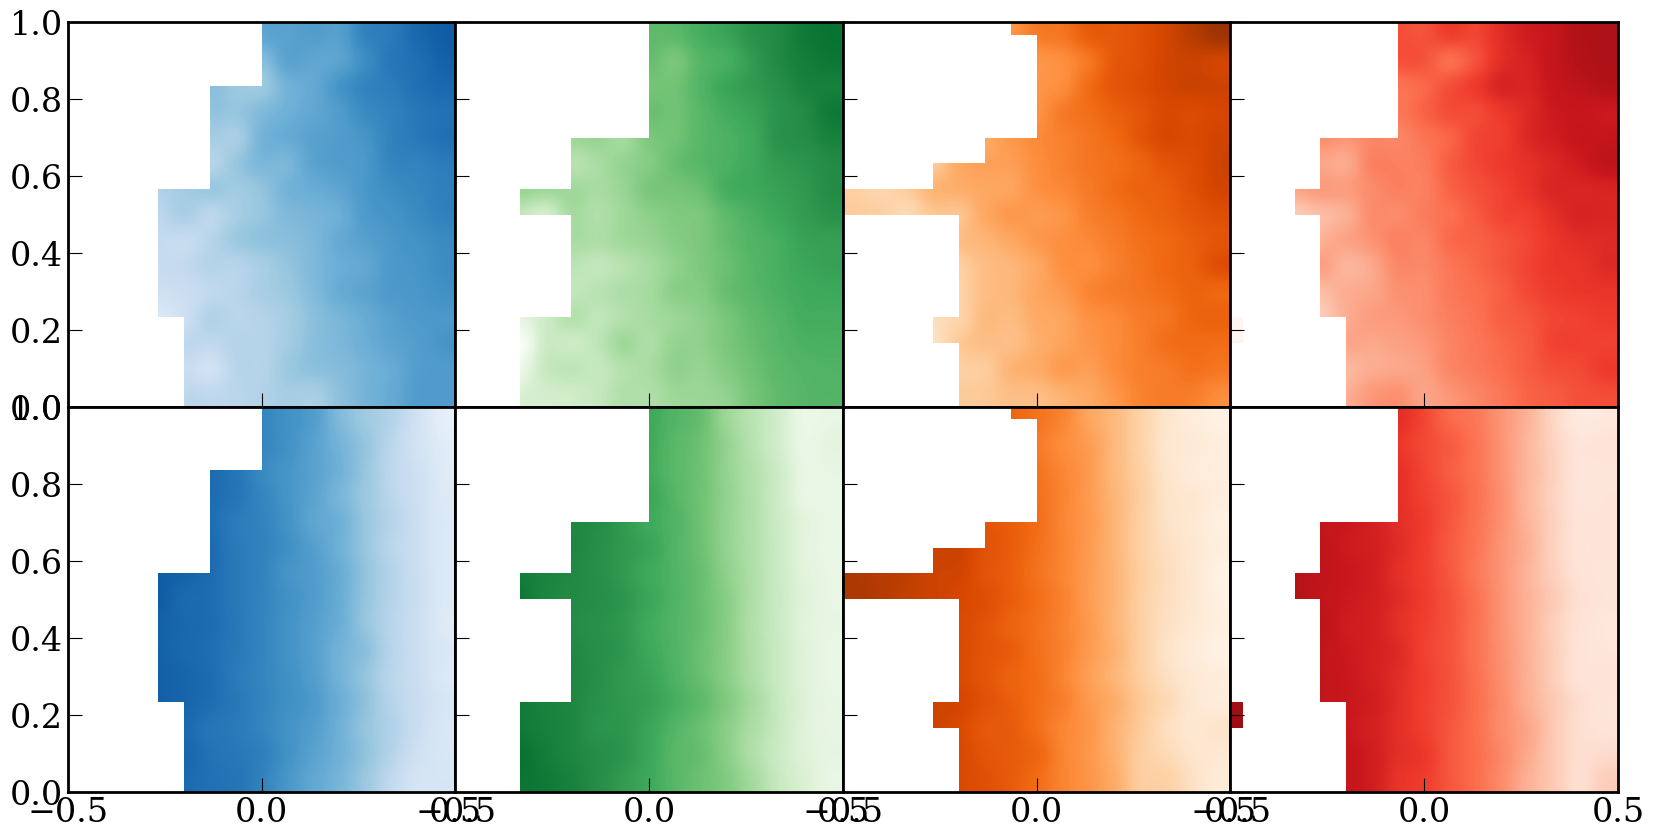

In [56]:
fig,ax=plt.subplots(2,4,figsize=(20,10),sharey=True,sharex=True)

for i,k in enumerate(bands):
    zspec = sources['zspec'].iloc[smorph['ind1']]
    #rmag = sources['rmag'].iloc[smorph['ind1']]
    mst = sources['logM'].iloc[smorph['ind1']]
    snr = np.log10(smorph['snr_pix_'+key])
    #res = 3+np.log10(sources['psfsize_'+k].iloc[smorph['ind1']]*cosmo.comoving_distance(zspec).value/rd2deg)

    #print(np.amin(res),np.amax(res),np.amin(snr),np.amax(snr))
    median_hist_2d(ax[0,i],res,snr,XYext = [-0.5,0.5,0,1],CMAP=bands[k][0],Xlabel=r'${\rm Spec.}\ {\it z}$',Ylabel=r'$DECaLS\ r\ (mag)$',Z=mst,Zext=[7,10],Zlabel=r'${\it g-r}$')
    
    median_hist_2d(ax[1,i],res,snr,XYext = [-0.5,0.5,0,1],CMAP=bands[k][0].reversed(),Xlabel=r'${\rm Spec.}\ {\it z}$',Ylabel=r'$DECaLS\ r\ (mag)$',Z=zspec,Zext=[0,0.1],Zlabel=r'${\it g-r}$')

plt.subplots_adjust(wspace=0.0,hspace=0.0)


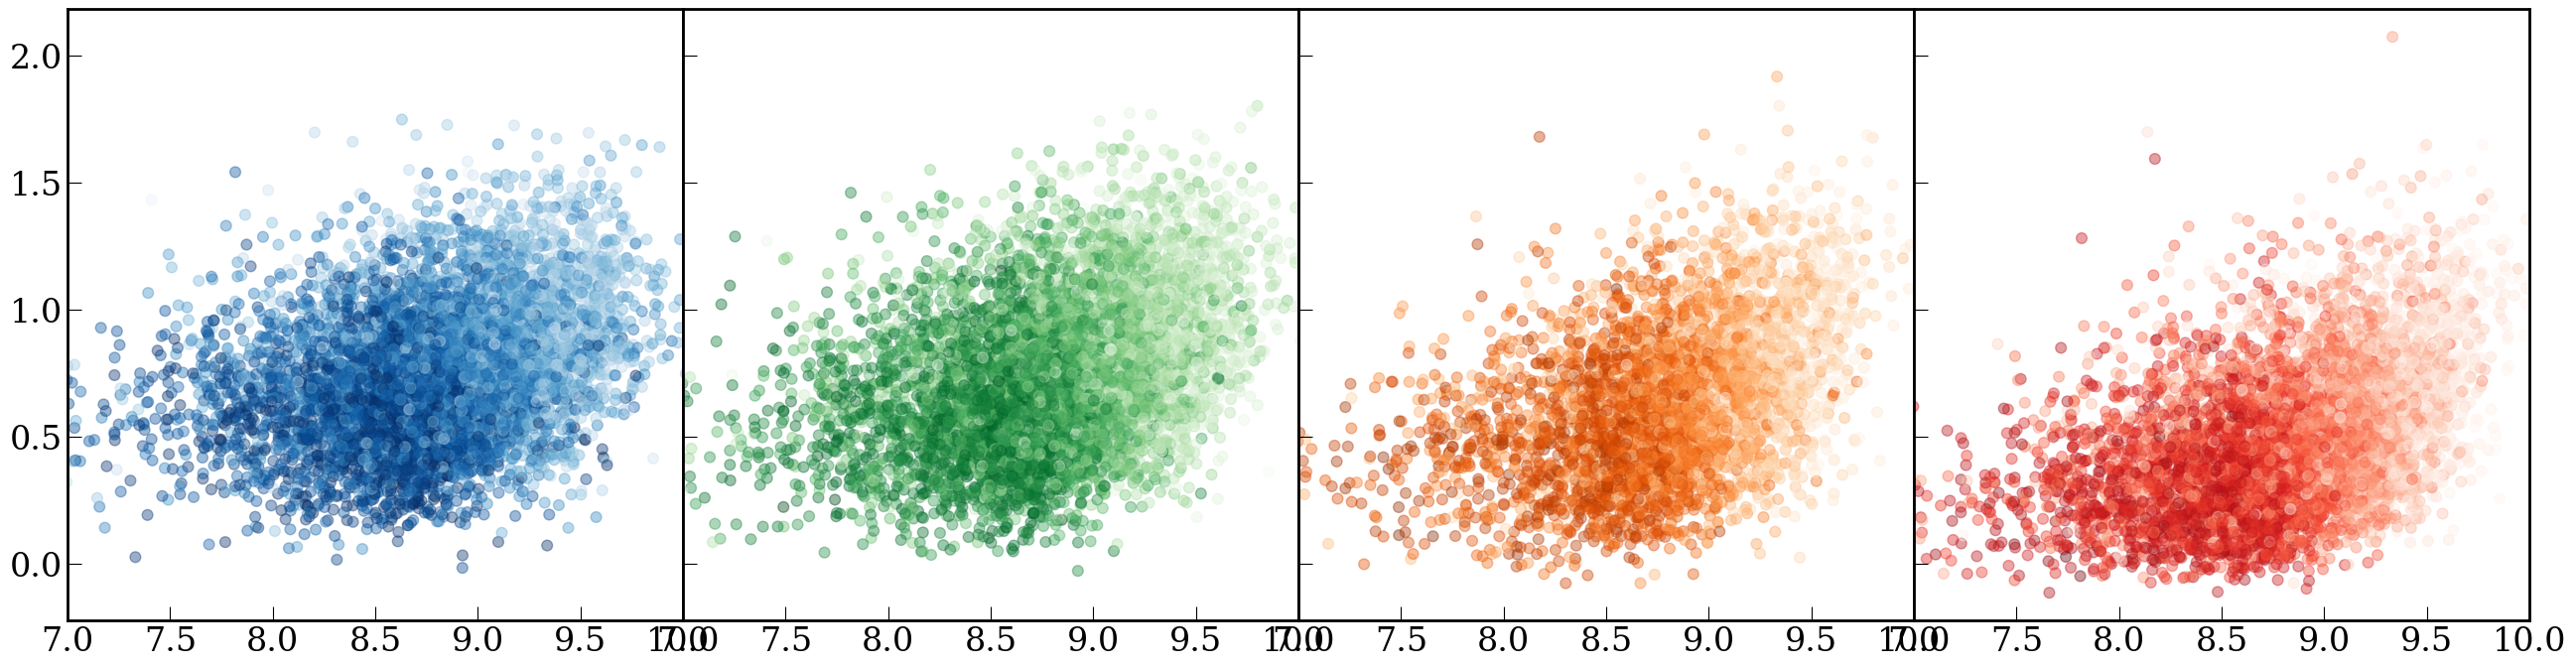

In [15]:
fig,ax=plt.subplots(1,4,figsize=(32,8),sharey=True)

for i,key in enumerate(bands):
    mst = sources['logM'].iloc[smorph['ind1']]
    mag = sources['m_'+key+'0'].iloc[smorph['ind1']]

    ax[i].scatter(mst,np.log10(smorph['snr_pix_'+key]),alpha=0.4,c=mag,s=60,cmap=bands[key][0],vmin=18,vmax=21)
    ax[i].set_xlim((7,10))
#ax.scatter(rmag,sfbr,alpha=0.4,s=60,c='none',edgecolor='black')

plt.subplots_adjust(wspace=0.0,hspace=0.0)


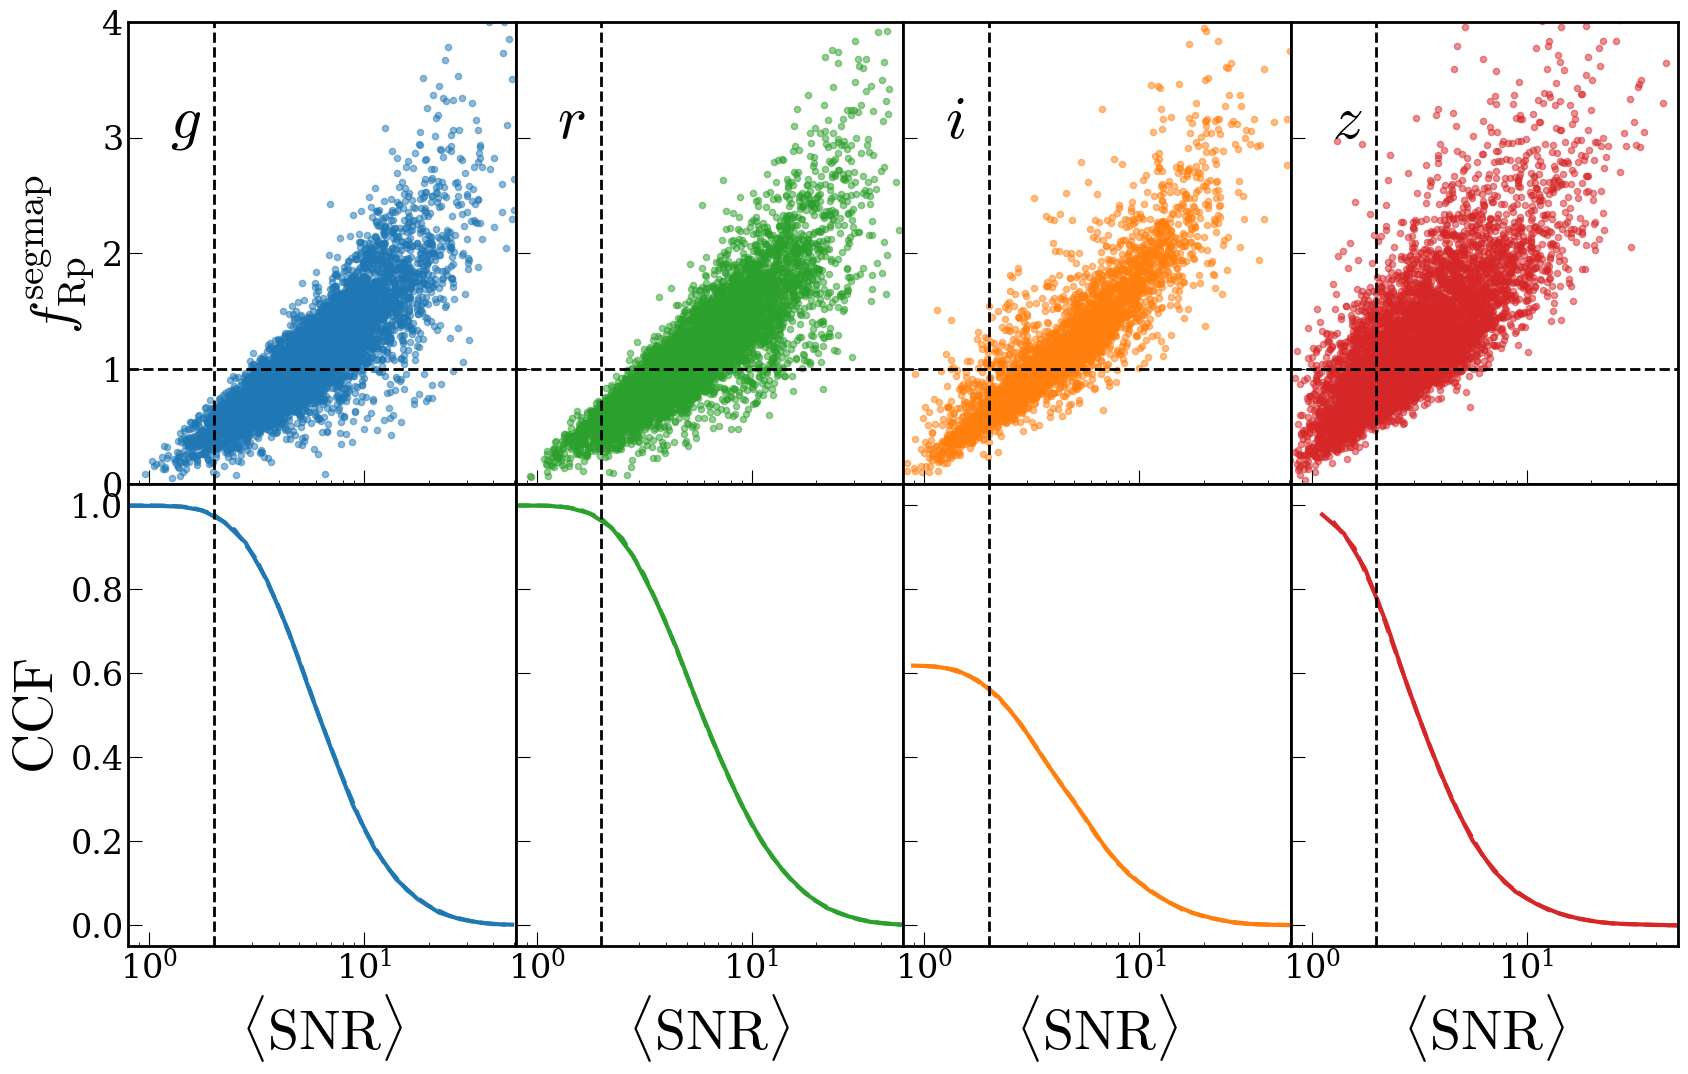

In [11]:
#high_snr = np.where((morph_all[:,0,10]>1)&(morph_all[:,1,10]>1))[0]
#print(len(high_snr))
fig,ax=plt.subplots(2,4,figsize=(20,12),sharey='row',sharex='col')

ls_fg = ['-','--']
snr_bins = np.logspace(np.log10(0.5),np.log10(50),21)

for i,key in enumerate(bands):
    selc = smorph[smorph['flag_'+key]<=1]

    #ax[0,i].scatter(morph_all[~flag1,i,10],morph_all[~flag1,i,11],alpha=0.2,c=griz_col[i],s=40)
    ax[0,i].scatter(selc['snr_pix_'+key],selc['segm_petr_'+key],alpha=0.5,c=griz_col[i],s=20)

    
    for l,sl in enumerate([smorph,selc]):
        bin_sat, bin_edg = np.histogram(sl['snr_pix_'+key],bins=snr_bins)
        bin_edg*=np.sqrt(bin_edg[1]/bin_edg[0])
        bin_sat=np.cumsum(bin_sat[::-1])[::-1]/len(sl['snr_pix_'+key])
        ax[1,i].plot(bin_edg[:-1],bin_sat,c=griz_col[i],lw=3,ls=ls_fg[l])


    ax[0,i].axhline(1.0,lw=2,ls='--',color='black',zorder=101)
    #ax[0,i].axvline(5.0,lw=2,ls='-.',color='black',zorder=101)
    #ax[1,i].axvline(5.0,lw=2,ls='-.',color='black',zorder=101)

    ax[0,i].axvline(2.0,lw=2,ls='--',color='black',zorder=101)
    ax[1,i].axvline(2.0,lw=2,ls='--',color='black',zorder=101)


    ax[0,i].text(1.25,3,r'${\it '+key+'}$',fontsize=44)
    ax[0,i].set_xscale('log')
    ax[0,i].set_xlim((0.8,50.8))
    ax[0,i].set_ylim((0,4))
    ax[1,i].set_xlabel(r'$\langle SNR \rangle$',fontsize=40)
ax[0,0].set_ylabel( r'${\it f}^{segmap}_{Rp}$',fontsize=40)
ax[1,0].set_ylabel( r'$CCF$',fontsize=40)
        

#ax.scatter(rmag,sfbr,alpha=0.4,s=60,c='none',edgecolor='black')

plt.subplots_adjust(wspace=0.0,hspace=0.0)
plt.savefig('SNRdistributions.pdf',bbox_inches='tight')


In [5]:
from sklearn.neighbors import KernelDensity

def gaussian_2d(xy, amplitude, x0, y0, sx, sy, offset):
    x, y = xy
    x_part,y_part = np.square((x - x0) / sx),np.square((y - y0) / sy)
    return offset + amplitude * np.exp(-0.5 * (x_part + y_part))

def hess_arr(x_val,y_val,hdex,nbins):
    x_val = (x_val - hdex[0])/(hdex[1]-hdex[0])
    y_val = (y_val - hdex[2])/(hdex[3]-hdex[2])
    dz=1.0/nbins
    
    xx,yy=np.meshgrid(np.arange(dz,1+dz,dz),np.arange(dz,1+2*dz,dz))
    xy_sample = np.vstack([yy[:-1].ravel(), xx[:-1].ravel()]).T
    xy_train  = np.vstack([y_val,x_val]).T

    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.05)
    kde_skl.fit(xy_train)
    hss_est = np.exp(np.reshape(kde_skl.score_samples(xy_sample),(nbins,nbins)))
    #hss_est = hss_est/((hdex[3] - hdex[2])*(hdex[1] - hdex[0]))
    hss_est = hss_est/np.sum(hss_est)
    #hss_est = hss_est/np.amax(hss_est)
    #print(dz*dz*np.sum(hss_est))

    x_flat,y_flat = xx[:-1].ravel(),yy[:-1].ravel()
    data_flat = hss_est.ravel()

    initial_guesses = [np.amax(data_flat), np.mean(x_val), np.mean(y_val), 1.0, 1.0, np.amin(data_flat)]

    # Perform the curve fitting
    popt, pcov = curve_fit(gaussian_2d,(x_flat, y_flat),data_flat,p0=initial_guesses)
    popt[1:5] = popt[1]*(hdex[1]-hdex[0]) + hdex[0], popt[1]*(hdex[3]-hdex[2]) + hdex[2],np.abs(popt[3]*(hdex[1]-hdex[0])),np.abs(popt[4]*(hdex[3]-hdex[2]))
    perr = np.sqrt(np.abs(np.diag(pcov)))
    perr[1:5] = np.abs(perr[1]*(hdex[1]-hdex[0])),np.abs(perr[2]*(hdex[3]-hdex[2])),np.abs(perr[3]*(hdex[1]-hdex[0])),np.abs(perr[4]*(hdex[3]-hdex[2]))

    #print(popt)
    #print(pcov)

    return hss_est,popt,perr

(4325, 78)
[ 9.54464258e-03 -1.62722714e+00  4.43193215e-01  1.00380953e-01
  3.26477088e-02  7.93257561e-05] [8.29681768e-05 8.72540682e-04 2.83786806e-04 9.03957628e-04
 2.93962005e-04 1.12853086e-05]
(4088, 78)
[ 9.86114161e-03 -1.65299222e+00  4.36751946e-01  9.99890782e-02
  3.20586001e-02  7.35884084e-05] [7.85358427e-05 7.96316899e-04 2.55312112e-04 8.23984634e-04
 2.64280254e-04 1.05306348e-05]
(2025, 78)
[ 9.52545879e-03 -1.66666807e+00  4.33332984e-01  1.01848486e-01
  3.21344296e-02  8.13695363e-05] [7.66259904e-05 8.19253534e-04 2.58473221e-04 8.48221340e-04
 2.67805122e-04 1.04067619e-05]
(1868, 78)
[ 1.01201655e-02 -1.67328460e+00  4.31678850e-01  9.59922350e-02
  3.23067911e-02  7.75528231e-05] [8.68547236e-05 8.23818895e-04 2.77254547e-04 8.51203010e-04
 2.86624553e-04 1.14013475e-05]


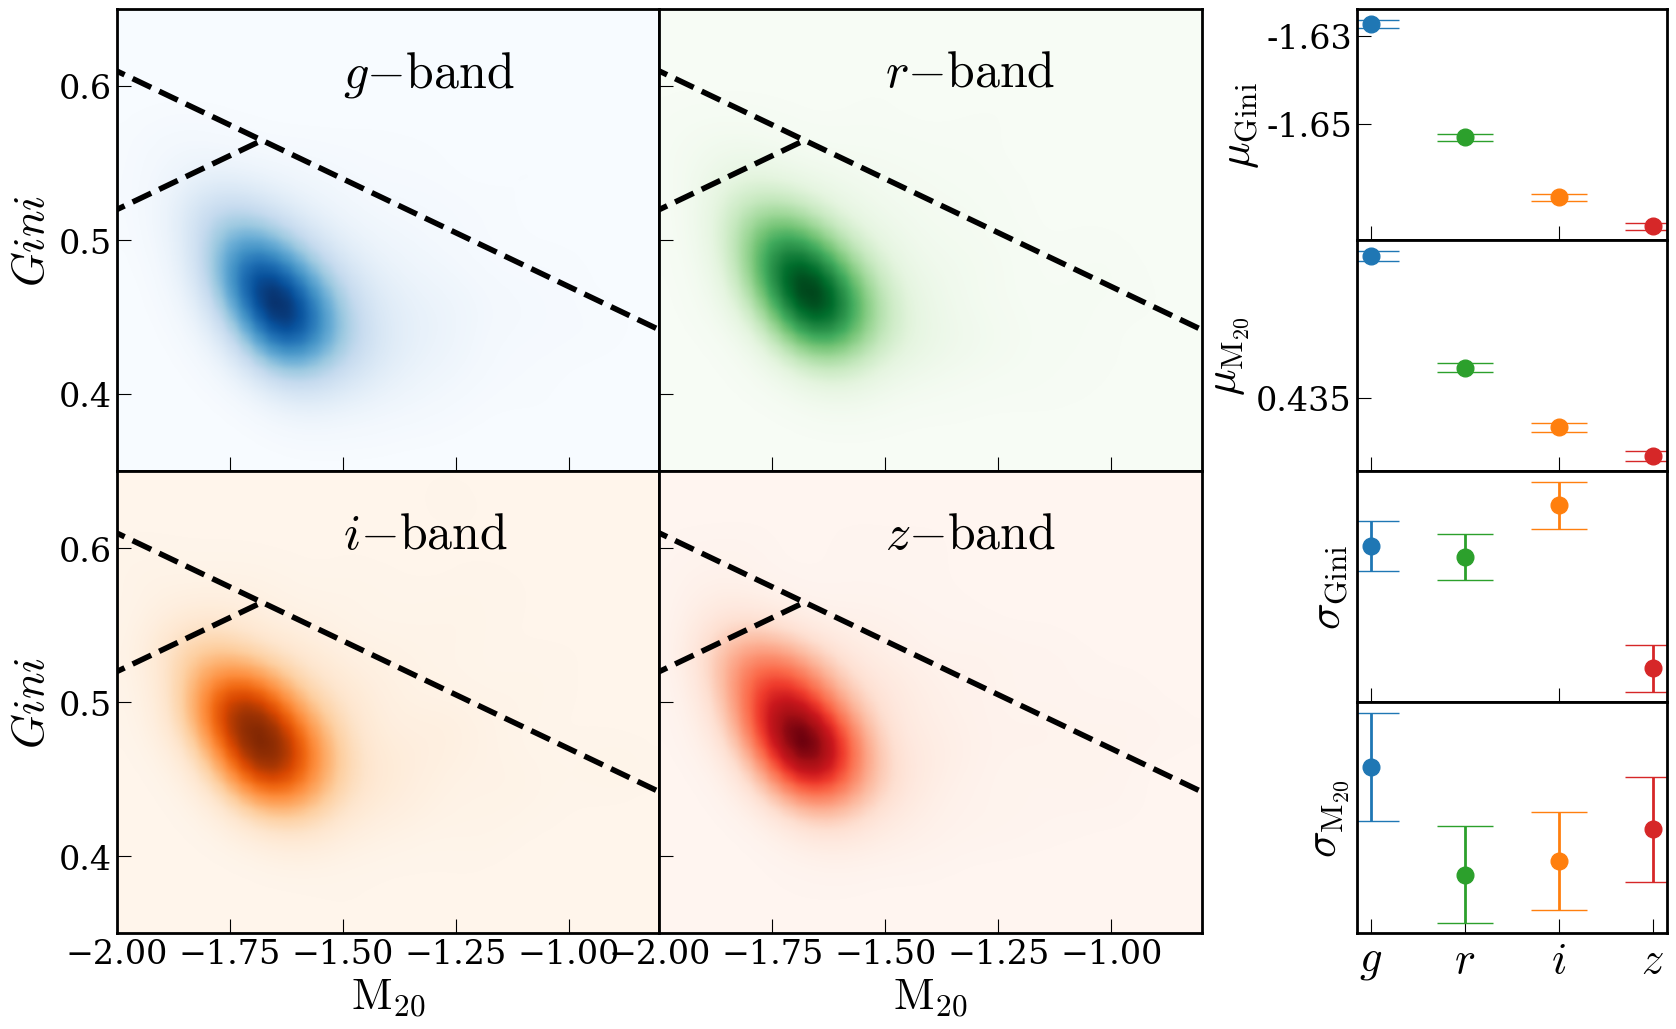

In [11]:
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(4, 4, figure=fig,width_ratios=[0.35,0.35,0.1,0.2])


axl = np.array([[fig.add_subplot(gs[0:2, 0]),fig.add_subplot(gs[0:2, 1])],[fig.add_subplot(gs[2:4, 0]),fig.add_subplot(gs[2:4, 1])]]) # Top-left 2x2
axl[0,0].set_xticklabels([])
axl[0,1].set_yticklabels([])
axl[0,1].set_xticklabels([])
axl[1,1].set_yticklabels([])

axr = [fig.add_subplot(gs[0, 3]),fig.add_subplot(gs[1, 3]),fig.add_subplot(gs[2, 3]),fig.add_subplot(gs[3, 3])] # Bottom-right
axr[0].set_xticklabels([])
axr[1].set_xticklabels([])
axr[2].set_xticklabels([])


hdx = [-2.0,-0.8,0.35,0.65]
M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)

for i,key in enumerate(bands):

    selc = smorph[(smorph['snr_pix_'+key]>2)&(smorph['flag_'+key]<=1)]
    print(selc.shape)

    axl[i//2,i%2].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    axl[i//2,i%2].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    
    hss_arr,p0,p1 = hess_arr(selc['m20_'+key],selc['gini_'+key], hdx,40)
    im = axl[i//2,i%2].imshow(hss_arr,cmap=bands[key][0],aspect='auto',extent = hdx,origin='lower',interpolation='gaussian')
    #im = ax[i//2,i%2].scatter(selc['m20_'+key],selc['gini_'+key],c=mst,s=40,cmap=bands[key],vmin=6,vmax=10,alpha=0.8)
    print(p0,p1)
    for j,ley in enumerate(range(1,5)):
        axr[j].errorbar(i,p0[ley],yerr=p1[ley],color=bands[key][1],marker='o',markersize=12,elinewidth=2,capsize=20)

    '''
    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    '''
    axl[i//2,i%2].text(-1.5,0.6,labels[i]+r'$-band$',fontsize=36)
    axl[i//2,i%2].set_ylim((0.35,0.65))
    axl[i//2,i%2].set_xlim((-2.0,-0.8))

for j in range(2):
    axl[j,0].set_ylabel( r'${\it Gini}$',fontsize=32)
    axl[1,j].set_xlabel(r'$M_{20}$',fontsize=32)
    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=bands[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')
axr[-1].xaxis.set_major_locator(ticker.FixedLocator(positions))
axr[-1].xaxis.set_major_formatter(ticker.FixedFormatter(labels))

tick_form = [[-1.65,-1.63],[0.435,0.445],[0.108,0.112],[3.3e-2,3.4e-2]]
tick_lab = [r'$\mu_{Gini}$',r'$\mu_{M_{20}}$',r'$\sigma_{Gini}$',r'$\sigma_{M_{20}}$']
for i in range(4):
    axr[i].set_ylabel(tick_lab[i],fontsize=32)
    axr[i].yaxis.set_major_locator(ticker.FixedLocator(tick_form[i]))
    axr[i].yaxis.set_major_formatter(ticker.FixedFormatter([str(l) for l in tick_form[i]]))
axr[-1].tick_params(axis='x', labelsize=32)

plt.subplots_adjust(wspace=0.0,hspace=0.0)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

g 3476
r 3433
i 2434
z 2565


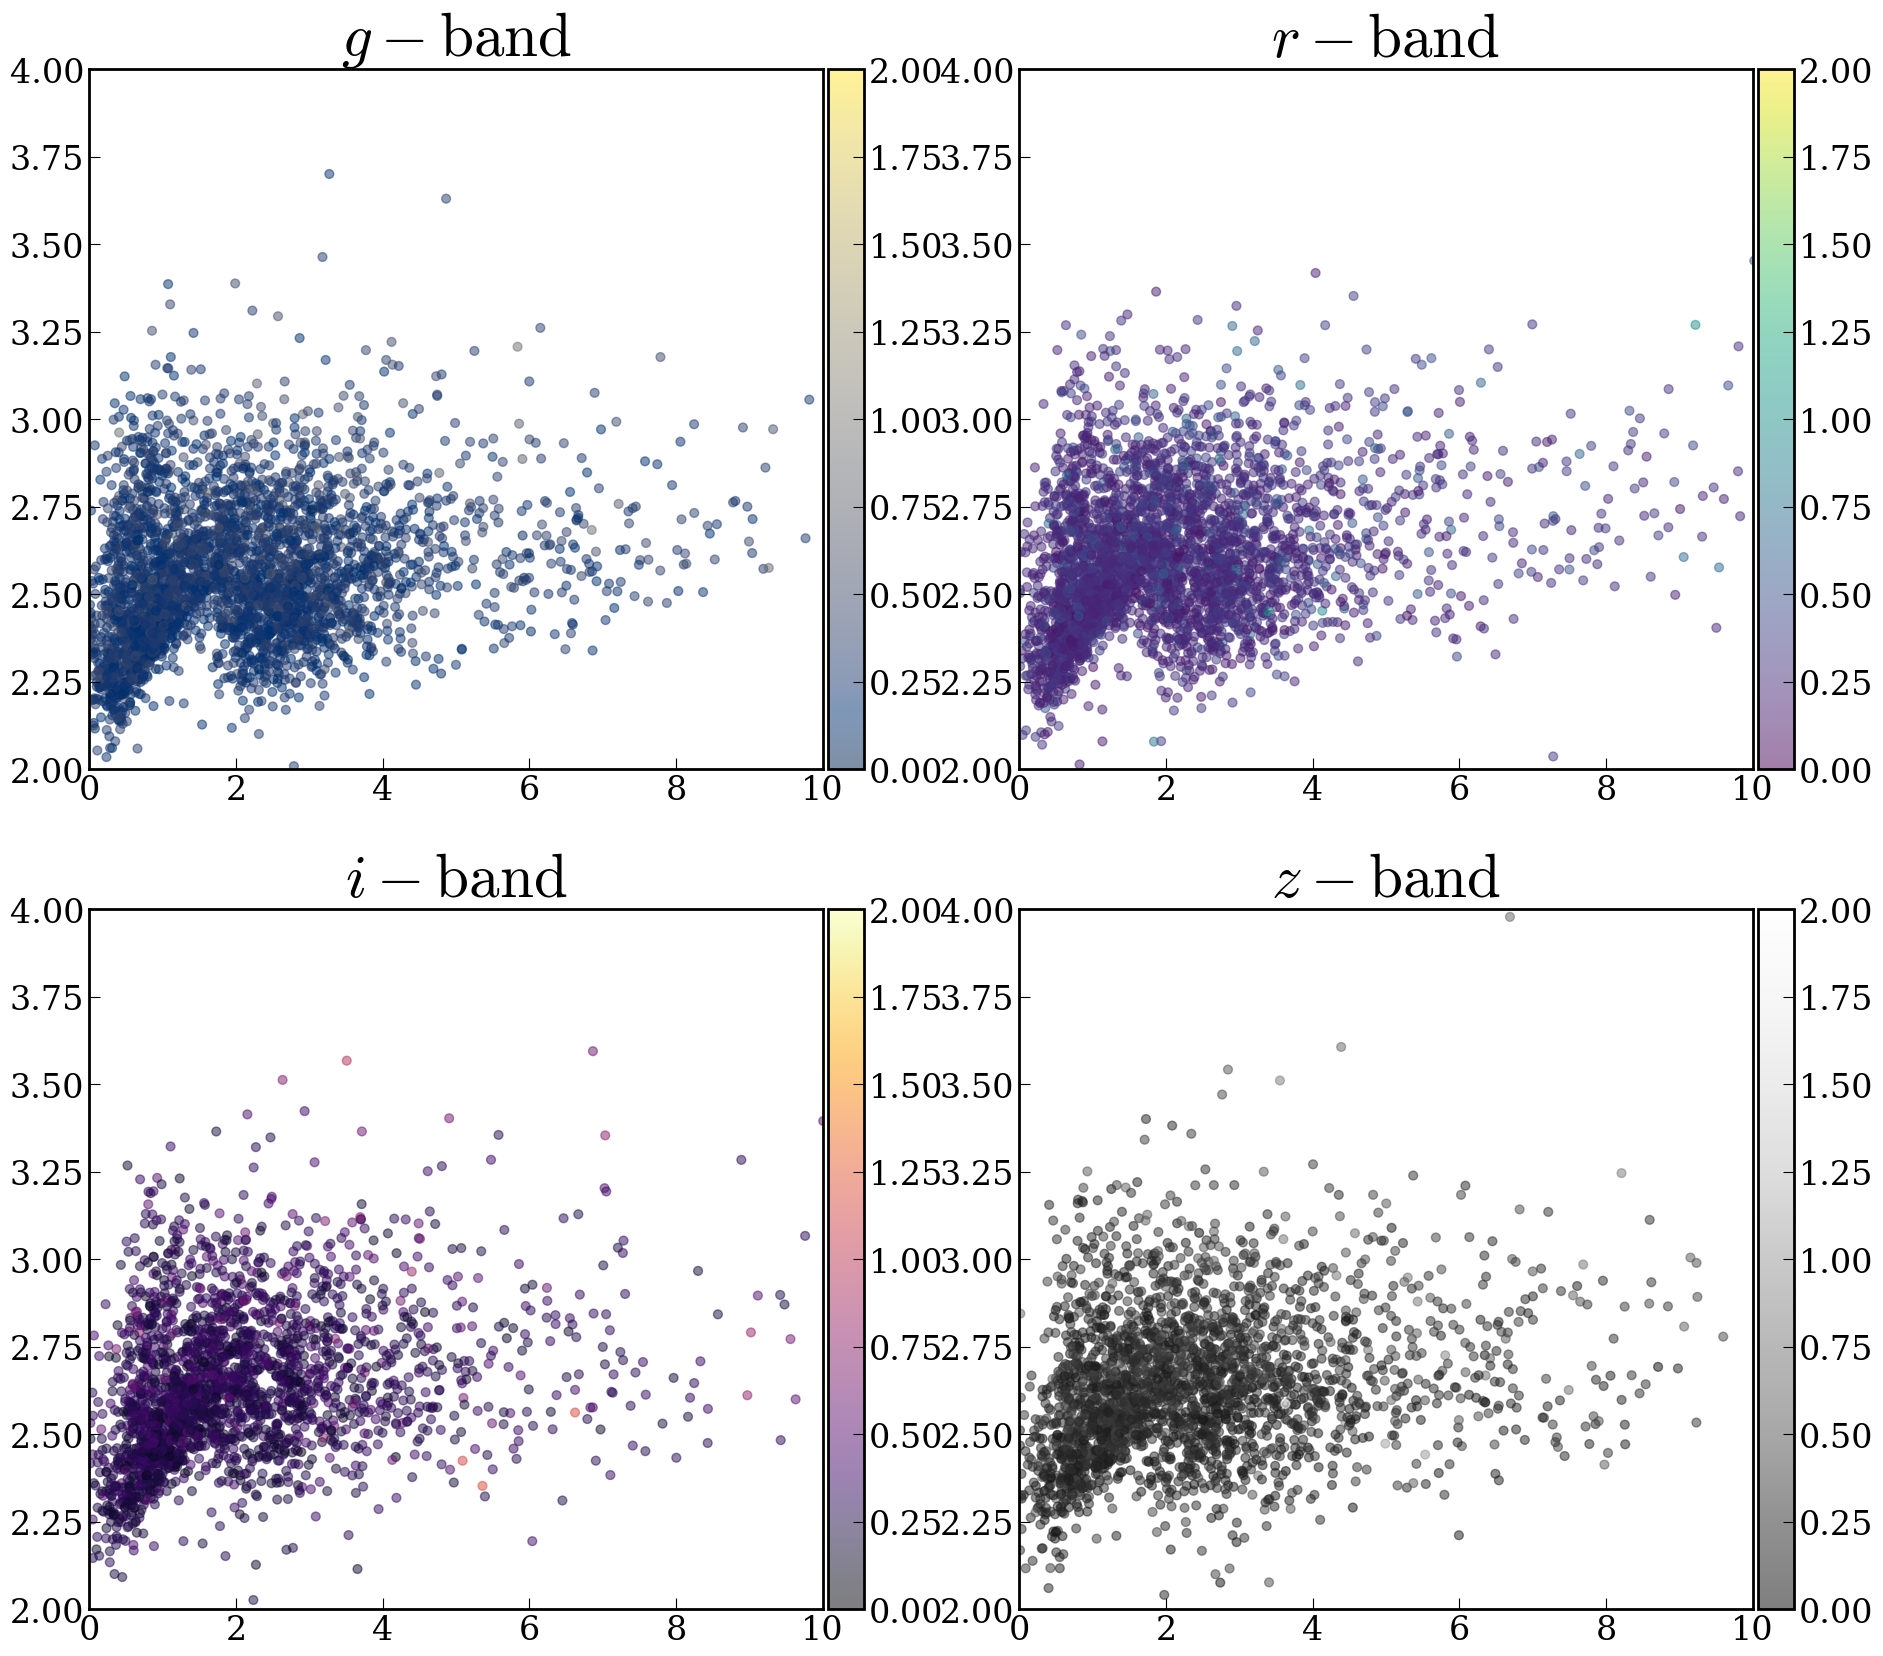

In [17]:
fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(bands):
    selc = np.where((sersic_all[:,i,3]==0)&(morph_all[:,i,10]>=2))[0]
    if i==2: selc = np.where((sersic_all[:,i,3]==0)&(morph_all[:,i,10]>=2)&(~np.isnan(sources['m_i0'].iloc[morph_all[:,i,0]])))[0]
    print(k,len(selc))
    
    #ax[i//2,i%2].scatter(sersic_all[~selc,i,0],morph_all[~selc,i,5],c=morph_all[~selc,i,8],s=80,cmap=bands[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(sersic_all[selc,i,0],morph_all[selc,i,5],c=morph_all[selc,i,8],s=40,cmap=bands[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((2.0,4.0))
    ax[i//2,i%2].set_xlim((0.0,10.0))
    ax[i//2,i%2].set_rasterized(True)

#for j in range(2):
    #ax[j,0].set_ylabel( r'${\it Gini}$',fontsize=40)
    #ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)
    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=bands[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

In [ ]:
#merger_cand = np.where((morph_all[:,0,1]>merger_line(morph_all[:,0,2]))&(morph_all[:,0,2]>-1.5))[0]
merger_cand = high_snr[np.where((morph_all[high_snr,0,8]<0.3))[0]]

fig1,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)

M20_arr = np.linspace(-2,-0.5,11)
M20_arrhalf = np.linspace(-2,-1.68,11)


for i in range(4):
    mst = sources['logM'].iloc[morph_all[merger_cand,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])


    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    #ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].scatter(morph_all[merger_cand,i,8],morph_all[merger_cand,i,1],c=morph_all[merger_cand,i,8],s=120,cmap=filt_cmap[i],vmin=0,vmax=2,edgecolors='black')

    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((0,2))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)
    ax1[i].set_rasterized(True)

    plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=filt_cmap[i]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')


ax1[0].set_ylabel( r'${\it Gini}$',fontsize=40)



plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')
'''
fig1,ax1=plt.subplots(1,4,figsize=(24,8),sharey=True)

for i in range(4):
    #merger_cand = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]

    ax1[i].scatter(morph_all[merger_cand,i,2],morph_all[merger_cand,i,1],alpha=0.5,color=griz_col[i],s=40)

for i in range(4):
    #ax1[i].plot(M20_arr,merger_line(M20_arr),lw=3,ls='--',color='black')
    ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=3,ls='--',color='black')
    
    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((-2,-0.5))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=36)
    ax1[i].set_rasterized(True)

ax1[0].set_ylabel( r'${\it Gini}$',fontsize=36)

plt.subplots_adjust(wspace=0.0)
'''
for k in merger_cand:
        key = sources.iloc[k]
        pos = np.array([key['RA'],key['DEC']])
        try: im = plt.imread('post_cutouts/galseg_{:.4f}_{:.4f}.png'.format(pos[0],pos[1]))
        except: continue

        fig,ax=plt.subplots(figsize=(16,8))
        ax.imshow(im)


In [ ]:

fig,ax=plt.subplots(2,2,figsize=(22,20))

M20_arr = np.linspace(-2.2,-0.4,21)
M20_arrhalf = np.linspace(-2.2,-1.68,11)


for i,k in enumerate(bands):

    selc = np.where((morph_all[:,i,9]==0)&(morph_all[:,i,10]>=2))[0]
    print(k,len(selc))
    
    ax[i//2,i%2].scatter(morph_all[~selc,i,2],SGM(morph_all[~selc,i,1],morph_all[~selc,i,2]),c=morph_all[~selc,i,8],s=80,cmap=bands[k],vmin=0,vmax=2,alpha=0.3)
    im = ax[i//2,i%2].scatter(morph_all[selc,i,2],SGM(morph_all[selc,i,1],morph_all[selc,i,2]),c=morph_all[selc,i,8],s=40,cmap=bands[k],vmin=0,vmax=2,alpha=0.5)


    divider = make_axes_locatable(ax[i//2,i%2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax[i//2,i%2].set_title(r'${\it '+k+'}-band$',fontsize=44)
    ax[i//2,i%2].set_ylim((-0.2,0.4))
    ax[i//2,i%2].set_xlim((-2.2,-0.3))
    ax[i//2,i%2].set_rasterized(True)

for j in range(2):
    ax[j,0].set_ylabel( r'$S(G,M_{20})$',fontsize=40)
    ax[1,j].set_xlabel(r'$M_{20}$',fontsize=40)



    #plt.colorbar(mcm.ScalarMappable(norm=mcol.Normalize(vmin=0,vmax=2), cmap=bands[k]), ax=ax1[i],orientation='horizontal',label=r'$A_S$')

#plt.subplots_adjust(wspace=0.15)
#plt.savefig('NPdistributions1.pdf',bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (4,) and (1052,)

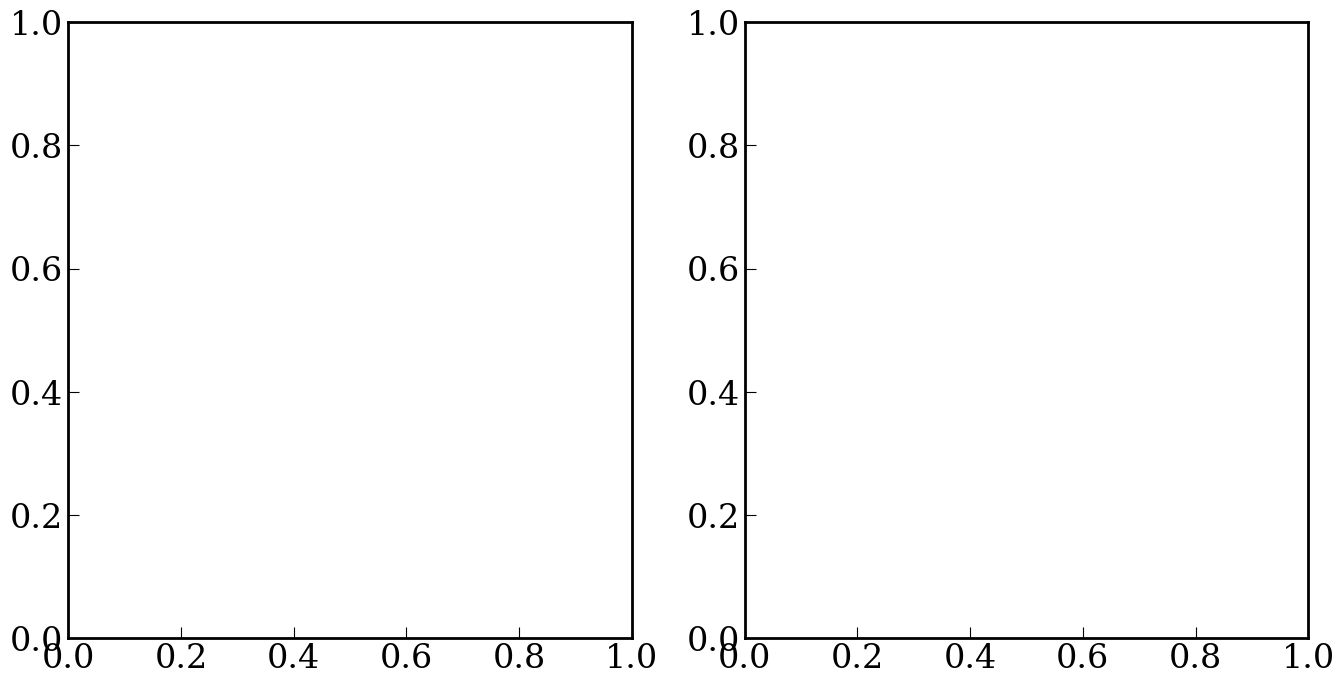

In [49]:
fig1,ax1=plt.subplots(1,2,figsize=(16,8))


for i in range(4):
    zsp = sources['zspec'].iloc[morph_all[high_snr,i,0]]

    ax1[0].plot(filt_arr,morph_all[high_snr,i,1],alpha=0.5,c=zsp,cmap=mcm.inferno,vmin=0,vmax=0.1)
    ax1[1].plot(filt_arr,morph_all[high_snr,i,2],alpha=0.5,c=zsp,cmap=mcm.inferno,vmin=0,vmax=0.1)
'''
    ax1[i].set_ylim((0.3,1.0))
    ax1[i].set_xlim((-2,-0.5))
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=36)
    ax1[i].set_rasterized(True)
'''
ax1[0].set_ylabel( r'${\it Gini}$',fontsize=36)